# 전자상거래 고객 이탈 예측 모델 개발
## AI 기반 고객 이탈 예측 및 분석 시스템

**프로젝트명**: 전자상거래 고객 이탈 예측 모델 개발 및 시각화  
**담당자**: [정혜원]  
**날짜**: 2025년 12월

---

### 📋 프로젝트 개요
- **목적**: 고객 이탈 패턴을 분석하여 사전에 이탈 가능성이 높은 고객을 식별하고 맞춤형 유지 전략 수립
- **데이터**: 전자상거래 고객 행동 데이터 (10,000건)
- **특성**: 24개 독립변수, 1개 타겟변수 (Churned)
- **모델**: 머신러닝 분류 모델 (Logistic Regression, Decision Tree, Random Forest, XGBoost)

## 1. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 전처리 및 평가
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

# 클래스 불균형 처리
from imblearn.over_sampling import SMOTE

# 머신러닝 모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ 라이브러리 임포트 완료")

✅ 라이브러리 임포트 완료


## 2. 데이터 로드 및 기본 정보 확인

In [2]:
# 데이터 로드
df = pd.read_csv('./dataset/ecommerce_customer_churn_dataset_10k.csv')

print("="*70)
print("데이터셋 기본 정보")
print("="*70)
print(f"\n📊 데이터 크기: {df.shape}")
print(f"   - 행(샘플) 수: {df.shape[0]:,}")
print(f"   - 열(특성) 수: {df.shape[1]}")

print(f"\n📋 컬럼 목록:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\n🎯 타겟 변수 분포:")
print(df['Churned'].value_counts())
print(f"\n이탈률: {df['Churned'].mean()*100:.2f}%")

# 상위 5개 데이터 확인
df.head()

데이터셋 기본 정보

📊 데이터 크기: (10000, 25)
   - 행(샘플) 수: 10,000
   - 열(특성) 수: 25

📋 컬럼 목록:
    1. Age
    2. Gender
    3. Country
    4. City
    5. Membership_Years
    6. Login_Frequency
    7. Session_Duration_Avg
    8. Pages_Per_Session
    9. Cart_Abandonment_Rate
   10. Wishlist_Items
   11. Total_Purchases
   12. Average_Order_Value
   13. Days_Since_Last_Purchase
   14. Discount_Usage_Rate
   15. Returns_Rate
   16. Email_Open_Rate
   17. Customer_Service_Calls
   18. Product_Reviews_Written
   19. Social_Media_Engagement_Score
   20. Mobile_App_Usage
   21. Payment_Method_Diversity
   22. Lifetime_Value
   23. Credit_Balance
   24. Churned
   25. Signup_Quarter

🎯 타겟 변수 분포:
Churned
0    7110
1    2890
Name: count, dtype: int64

이탈률: 28.90%


,Age,Gender,Country,City,Membership_Years,Login_Frequency,Session_Duration_Avg,Pages_Per_Session,Cart_Abandonment_Rate,Wishlist_Items,...,Email_Open_Rate,Customer_Service_Calls,Product_Reviews_Written,Social_Media_Engagement_Score,Mobile_App_Usage,Payment_Method_Diversity,Lifetime_Value,Credit_Balance,Churned,Signup_Quarter
0,32.0,Female,Germany,Munich,0.1,6.0,20.3,6.9,51.3,4.0,...,9.9,9.0,0.0,34.3,NaN,1.0,886.08,1668.0,0,Q3
1,32.0,Male,Canada,Calgary,3.4,9.0,21.0,6.7,56.7,4.0,...,NaN,7.0,4.0,46.4,15.7,2.0,1022.10,NaN,0,Q4
2,50.0,Female,Germany,Cologne,1.7,14.0,31.1,10.6,48.0,2.0,...,33.9,4.0,4.0,14.1,24.6,1.0,2770.19,2484.0,0,Q1
3,30.0,Female,India,Chennai,4.1,8.0,31.1,12.7,51.2,4.0,...,26.5,5.0,5.0,NaN,25.4,5.0,639.25,3231.0,0,Q1
4,39.0,Male,Canada,Ottawa,0.5,9.0,16.4,5.4,61.6,3.0,...,17.0,8.0,2.0,20.9,21.1,5.0,913.55,1817.0,0,Q2


In [3]:
# 데이터 타입 및 기본 통계
print("\n데이터 타입 정보:")
print(df.dtypes)

print("\n기술 통계량:")
df.describe()


데이터 타입 정보:
Age                              float64
Gender                            object
Country                           object
City                              object
Membership_Years                 float64
Login_Frequency                  float64
Session_Duration_Avg             float64
Pages_Per_Session                float64
Cart_Abandonment_Rate            float64
Wishlist_Items                   float64
Total_Purchases                  float64
Average_Order_Value              float64
Days_Since_Last_Purchase         float64
Discount_Usage_Rate              float64
Returns_Rate                     float64
Email_Open_Rate                  float64
Customer_Service_Calls           float64
Product_Reviews_Written          float64
Social_Media_Engagement_Score    float64
Mobile_App_Usage                 float64
Payment_Method_Diversity         float64
Lifetime_Value                   float64
Credit_Balance                   float64
Churned                            int64
Sign

,Age,Membership_Years,Login_Frequency,Session_Duration_Avg,Pages_Per_Session,Cart_Abandonment_Rate,Wishlist_Items,Total_Purchases,Average_Order_Value,Days_Since_Last_Purchase,...,Returns_Rate,Email_Open_Rate,Customer_Service_Calls,Product_Reviews_Written,Social_Media_Engagement_Score,Mobile_App_Usage,Payment_Method_Diversity,Lifetime_Value,Credit_Balance,Churned
count,9469.000000,10000.000000,10000.000000,9359.000000,9381.000000,10000.000000,9195.000000,10000.000000,10000.000000,9403.000000,...,9075.000000,9477.000000,9960.000000,9300.000000,8744.000000,9025.000000,9506.000000,10000.000000,8900.000000,10000.000000
mean,37.861759,2.957622,11.677300,27.645315,8.707078,57.180279,4.296683,13.083690,119.280480,30.084547,...,6.727396,20.882241,5.705522,2.840323,29.184744,19.259069,2.351357,1430.186790,1963.654382,0.289000
std,11.886939,2.054460,7.797361,10.764494,3.738901,16.169811,3.176907,7.116517,77.162073,30.102738,...,6.142718,14.186886,2.660894,2.336649,20.439131,9.328010,1.116208,903.064142,1217.996874,0.453321
min,5.000000,0.100000,0.000000,1.000000,1.000000,0.000000,0.000000,-13.000000,26.870000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,29.000000,1.400000,6.000000,19.700000,6.000000,46.400000,2.000000,8.000000,86.270000,9.000000,...,2.900000,9.900000,4.000000,1.000000,13.100000,12.600000,1.000000,780.545000,1039.000000,0.000000
50%,38.000000,2.500000,11.000000,26.800000,8.400000,58.300000,4.000000,12.000000,112.265000,21.000000,...,5.500000,19.700000,5.000000,2.000000,27.500000,18.500000,2.000000,1229.530000,1892.500000,0.000000
75%,46.000000,4.000000,17.000000,34.600000,11.100000,68.700000,6.000000,16.900000,143.592500,41.000000,...,9.100000,30.400000,7.000000,4.000000,42.700000,25.300000,3.000000,1867.487500,2808.250000,1.000000
max,200.000000,10.000000,44.000000,68.600000,22.700000,125.249416,21.000000,128.700000,6454.329430,276.000000,...,99.220802,91.700000,19.000000,21.000000,100.000000,53.800000,5.000000,7533.680000,7197.000000,1.000000


## 3. 탐색적 데이터 분석 (EDA)

### 3.1 결측치 분석

결측치 분석
                               결측치 개수  결측치 비율(%)
Social_Media_Engagement_Score    1256      12.56
Credit_Balance                   1100      11.00
Mobile_App_Usage                  975       9.75
Returns_Rate                      925       9.25
Wishlist_Items                    805       8.05
Product_Reviews_Written           700       7.00
Discount_Usage_Rate               692       6.92
Session_Duration_Avg              641       6.41
Pages_Per_Session                 619       6.19
Days_Since_Last_Purchase          597       5.97
Age                               531       5.31
Email_Open_Rate                   523       5.23
Payment_Method_Diversity          494       4.94
Customer_Service_Calls             40       0.40


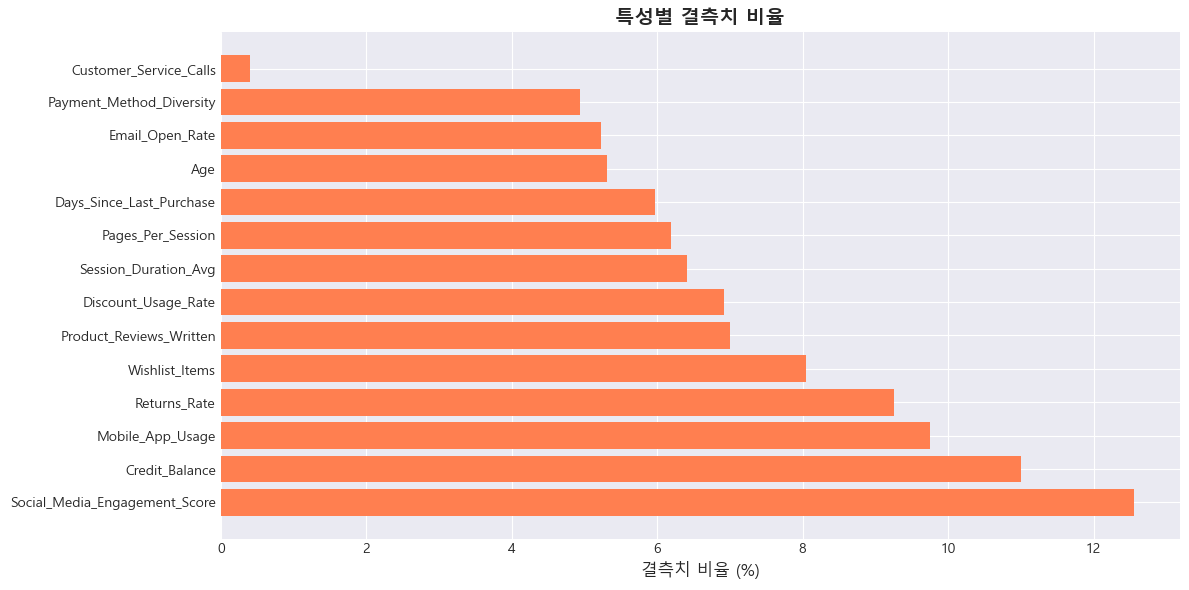

In [6]:
# 결측치 확인
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    '결측치 개수': missing_values,
    '결측치 비율(%)': missing_percent
}).sort_values(by='결측치 개수', ascending=False)

print("="*70)
print("결측치 분석")
print("="*70)
print(missing_df[missing_df['결측치 개수'] > 0])

# 시각화 부분
if missing_df['결측치 개수'].sum() > 0:
    plt.figure(figsize=(12, 6))
    
    # 이 줄을 추가하면 이 그래프에서 한글이 잘 나옵니다!
    plt.rc('font', family='Malgun Gothic') 
    
    missing_data = missing_df[missing_df['결측치 개수'] > 0]
    plt.barh(missing_data.index, missing_data['결측치 비율(%)'], color='coral')
    plt.xlabel('결측치 비율 (%)', fontsize=12)
    plt.title('특성별 결측치 비율', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ 결측치가 없습니다!")

### 3.2 타겟 변수 분포

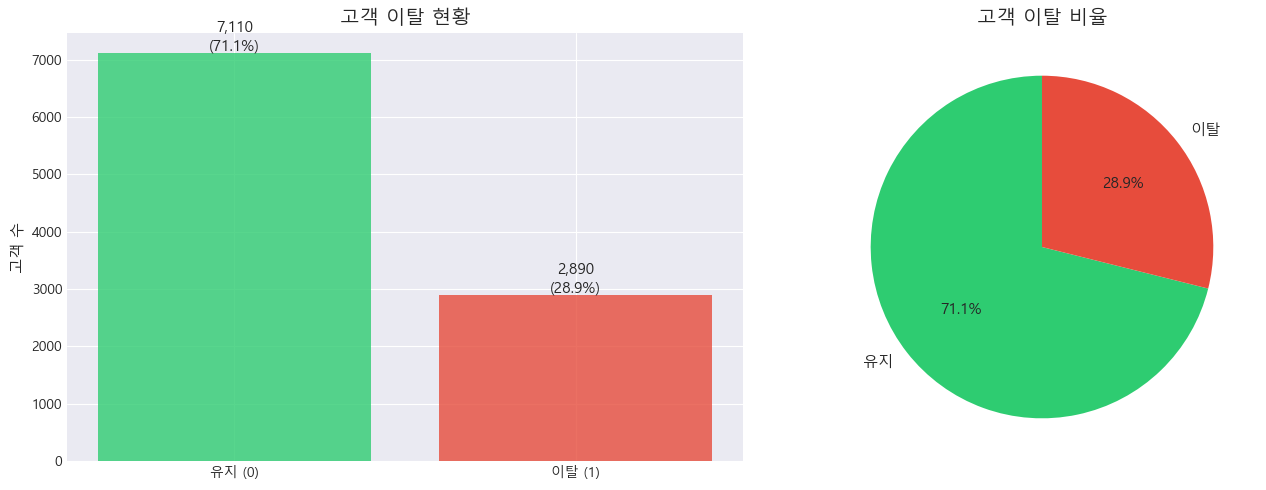


⚠️ 클래스 불균형 비율: 2.46:1 (유지:이탈)


In [7]:
# 3.2 타겟 변수 분포 시각화 (한글 깨짐 해결 버전)
import matplotlib.pyplot as plt

# 개별 그래프 내에서도 폰트를 다시 한번 확실히 지정 (강력한 해결책)
font_name = "Malgun Gothic" # Windows 기준

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 막대 그래프
churn_counts = df['Churned'].value_counts()
# x축 라벨 ('유지', '이탈') 명시적 지정
axes[0].bar(['유지 (0)', '이탈 (1)'], churn_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[0].set_ylabel('고객 수', fontsize=11, family=font_name)
# fontweight='bold'를 제거하고 fontsize를 조금 키우는 것이 한글에 안전합니다
axes[0].set_title('고객 이탈 현황', fontsize=14, family=font_name)

for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, f"{v:,}\n({v/len(df)*100:.1f}%)", ha='center', fontsize=11, family=font_name)

# 2. 파이 차트
axes[1].pie(churn_counts.values, labels=['유지', '이탈'], autopct='%1.1f%%', 
            colors=['#2ecc71', '#e74c3c'], startangle=90, textprops={'fontsize': 11, 'family': font_name})
axes[1].set_title('고객 이탈 비율', fontsize=14, family=font_name)

plt.tight_layout()
plt.show()

print(f"\n⚠️ 클래스 불균형 비율: {churn_counts[0]/churn_counts[1]:.2f}:1 (유지:이탈)")

### 3.3 수치형 변수 분포

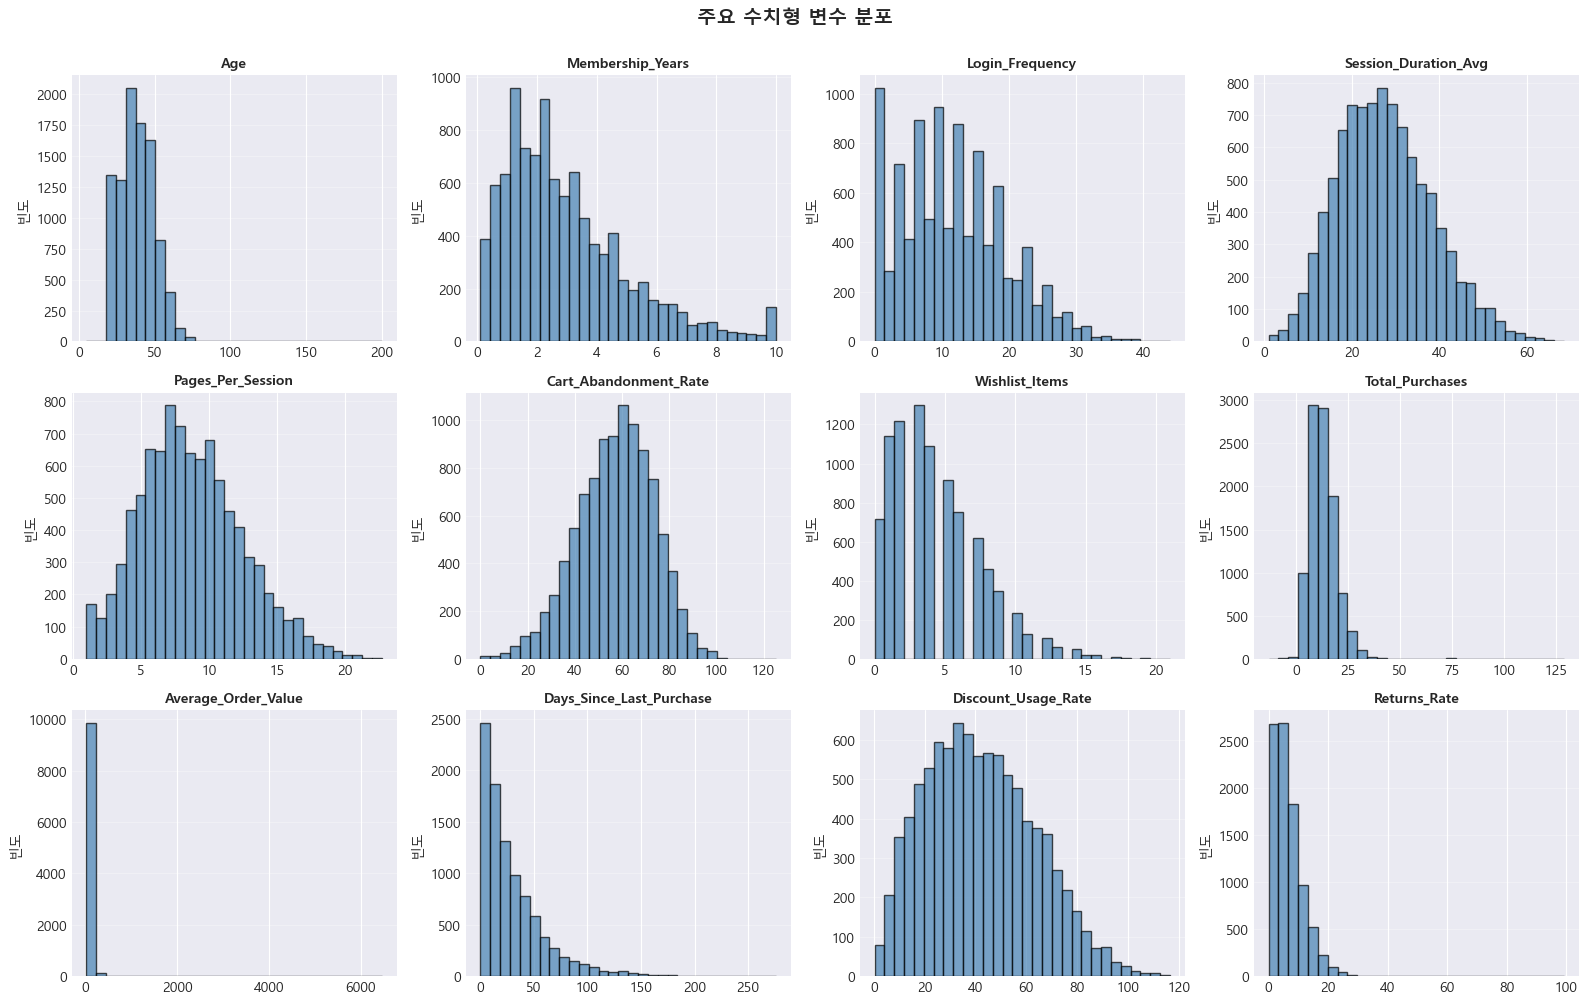

In [8]:
# 수치형 변수 추출
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('Churned')  # 타겟 제외

# 주요 수치형 변수 분포 시각화 (상위 12개)
important_numeric = numeric_cols[:12]
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(important_numeric):
    axes[idx].hist(df[col].dropna(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('빈도')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('주요 수치형 변수 분포', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 3.4 상관관계 분석 (Heatmap)

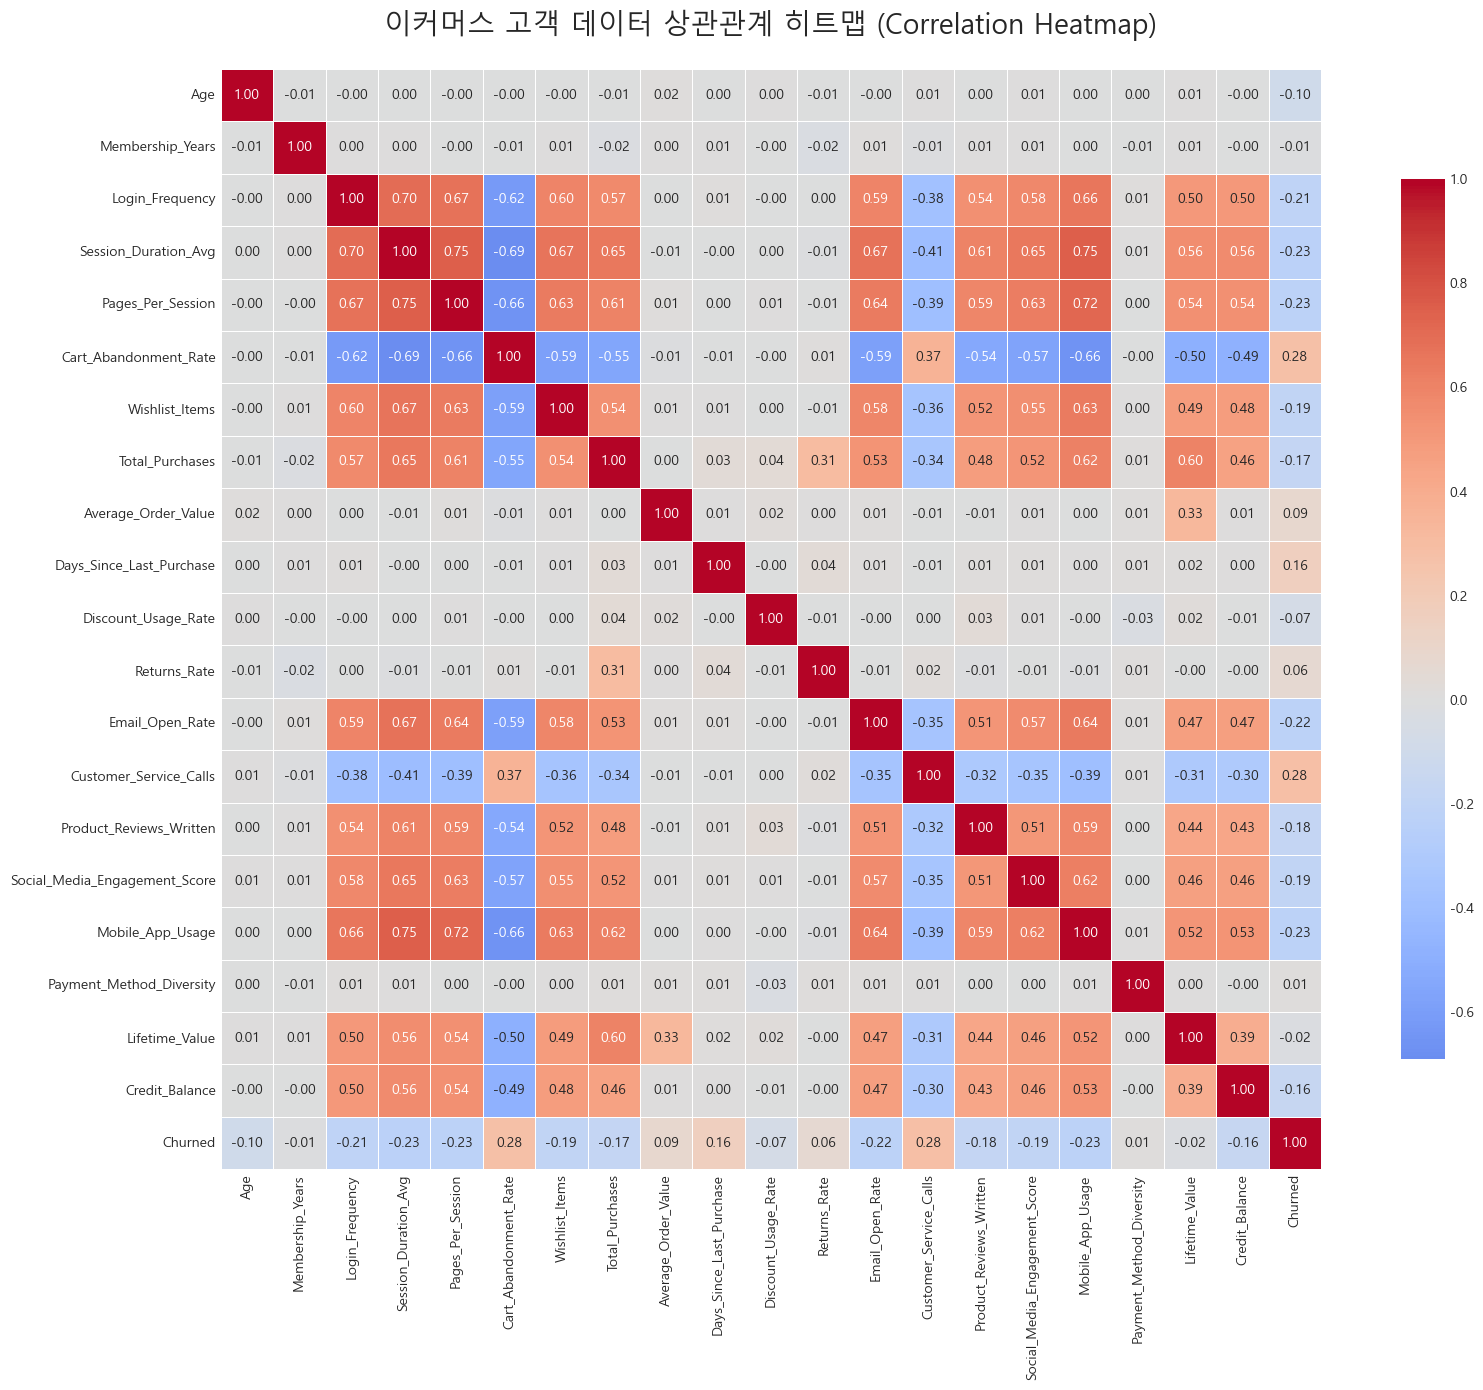


타겟 변수(Churned)와의 상관관계 Top 10:
Customer_Service_Calls      0.284175
Cart_Abandonment_Rate       0.277238
Days_Since_Last_Purchase    0.155397
Average_Order_Value         0.085521
Returns_Rate                0.064217
Payment_Method_Diversity    0.010745
Membership_Years           -0.010522
Lifetime_Value             -0.021142
Discount_Usage_Rate        -0.068556
Age                        -0.098851
Name: Churned, dtype: float64


In [9]:
# 3.4 상관관계 분석 (Heatmap) 해결 버전
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 이름 설정 (Windows: Malgun Gothic)
font_name = "Malgun Gothic"

# 수치형 변수만으로 상관관계 계산
correlation_matrix = df[numeric_cols + ['Churned']].corr()

# 히트맵 시각화
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# 제목 설정: fontweight='bold'를 제거하고 fontfamily를 명시적으로 지정합니다.
plt.title('이커머스 고객 데이터 상관관계 히트맵 (Correlation Heatmap)', 
          fontsize=20, family=font_name, pad=25)

plt.tight_layout()
plt.show()

# 타겟과 상관관계가 높은 변수 추출
target_corr = correlation_matrix['Churned'].drop('Churned').sort_values(ascending=False)
print("\n타겟 변수(Churned)와의 상관관계 Top 10:")
print("="*50)
print(target_corr.head(10))

### 3.5 범주형 변수 분석

범주형 변수: ['Gender', 'Country', 'City', 'Signup_Quarter']



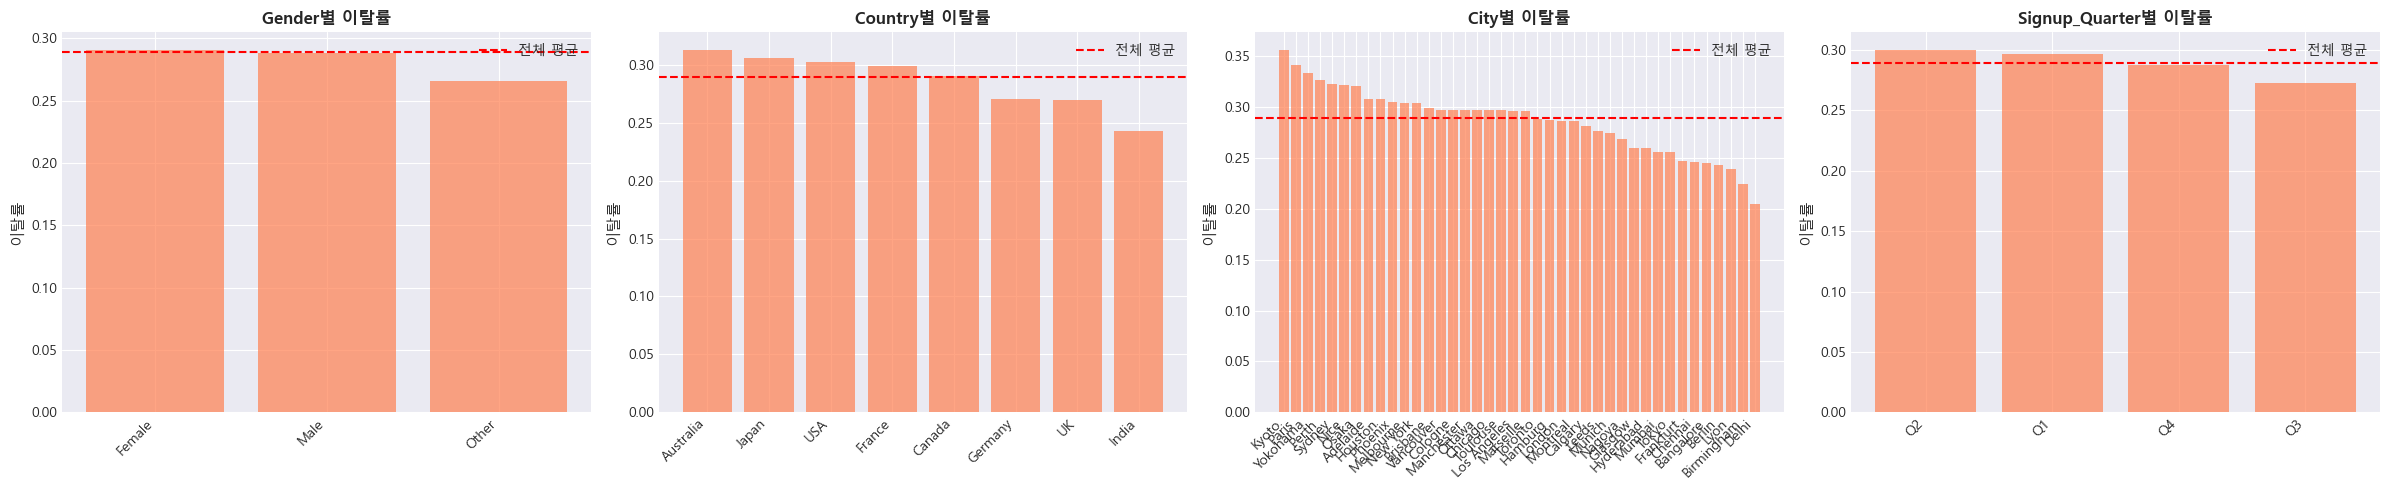

In [10]:
# 범주형 변수 추출
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    print(f"범주형 변수: {categorical_cols}\n")
    
    # 범주형 변수별 이탈률
    fig, axes = plt.subplots(1, len(categorical_cols), figsize=(6*len(categorical_cols), 5))
    
    if len(categorical_cols) == 1:
        axes = [axes]
    
    for idx, col in enumerate(categorical_cols):
        churn_rate = df.groupby(col)['Churned'].mean().sort_values(ascending=False)
        axes[idx].bar(range(len(churn_rate)), churn_rate.values, color='coral', alpha=0.7)
        axes[idx].set_xticks(range(len(churn_rate)))
        axes[idx].set_xticklabels(churn_rate.index, rotation=45, ha='right')
        axes[idx].set_ylabel('이탈률', fontsize=11)
        axes[idx].set_title(f'{col}별 이탈률', fontsize=12, fontweight='bold')
        axes[idx].axhline(y=df['Churned'].mean(), color='red', linestyle='--', label='전체 평균')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("범주형 변수가 없습니다.")

### 3.6 이상치 탐지 (Box Plot)

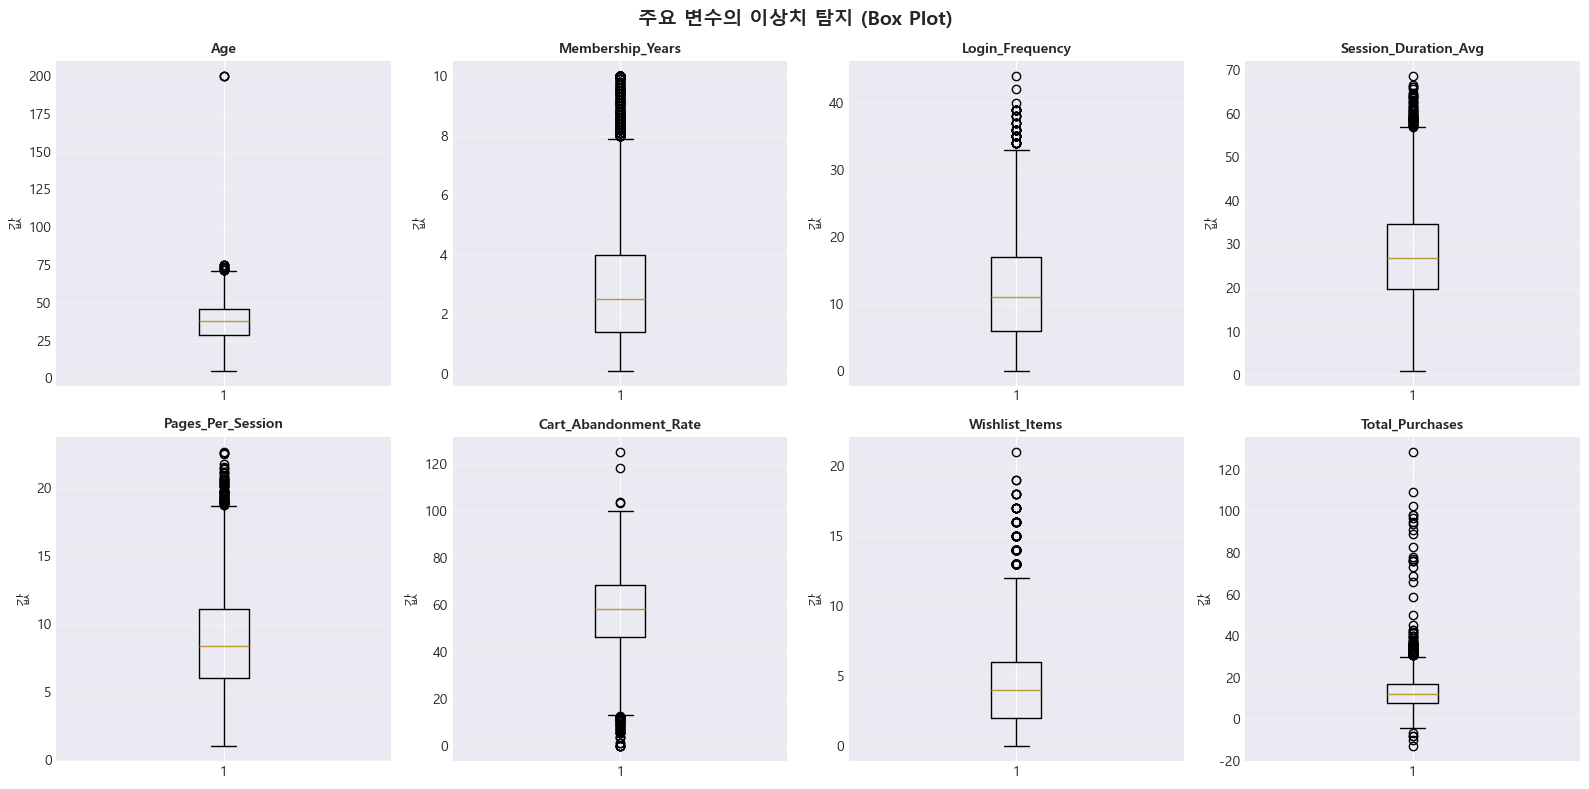


이상치 개수 (IQR 방법):
Age: 17 (0.17%)
Membership_Years: 309 (3.09%)
Login_Frequency: 52 (0.52%)
Session_Duration_Avg: 64 (0.64%)
Pages_Per_Session: 73 (0.73%)
Cart_Abandonment_Rate: 57 (0.57%)
Wishlist_Items: 168 (1.68%)
Total_Purchases: 119 (1.19%)


In [11]:
# 주요 변수의 이상치 시각화
important_for_outliers = numeric_cols[:8]
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(important_for_outliers):
    axes[idx].boxplot(df[col].dropna(), vert=True)
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('값')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('주요 변수의 이상치 탐지 (Box Plot)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# IQR 방법으로 이상치 개수 확인
print("\n이상치 개수 (IQR 방법):")
print("="*50)
for col in important_for_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

### 3.7 타겟별 주요 변수 비교

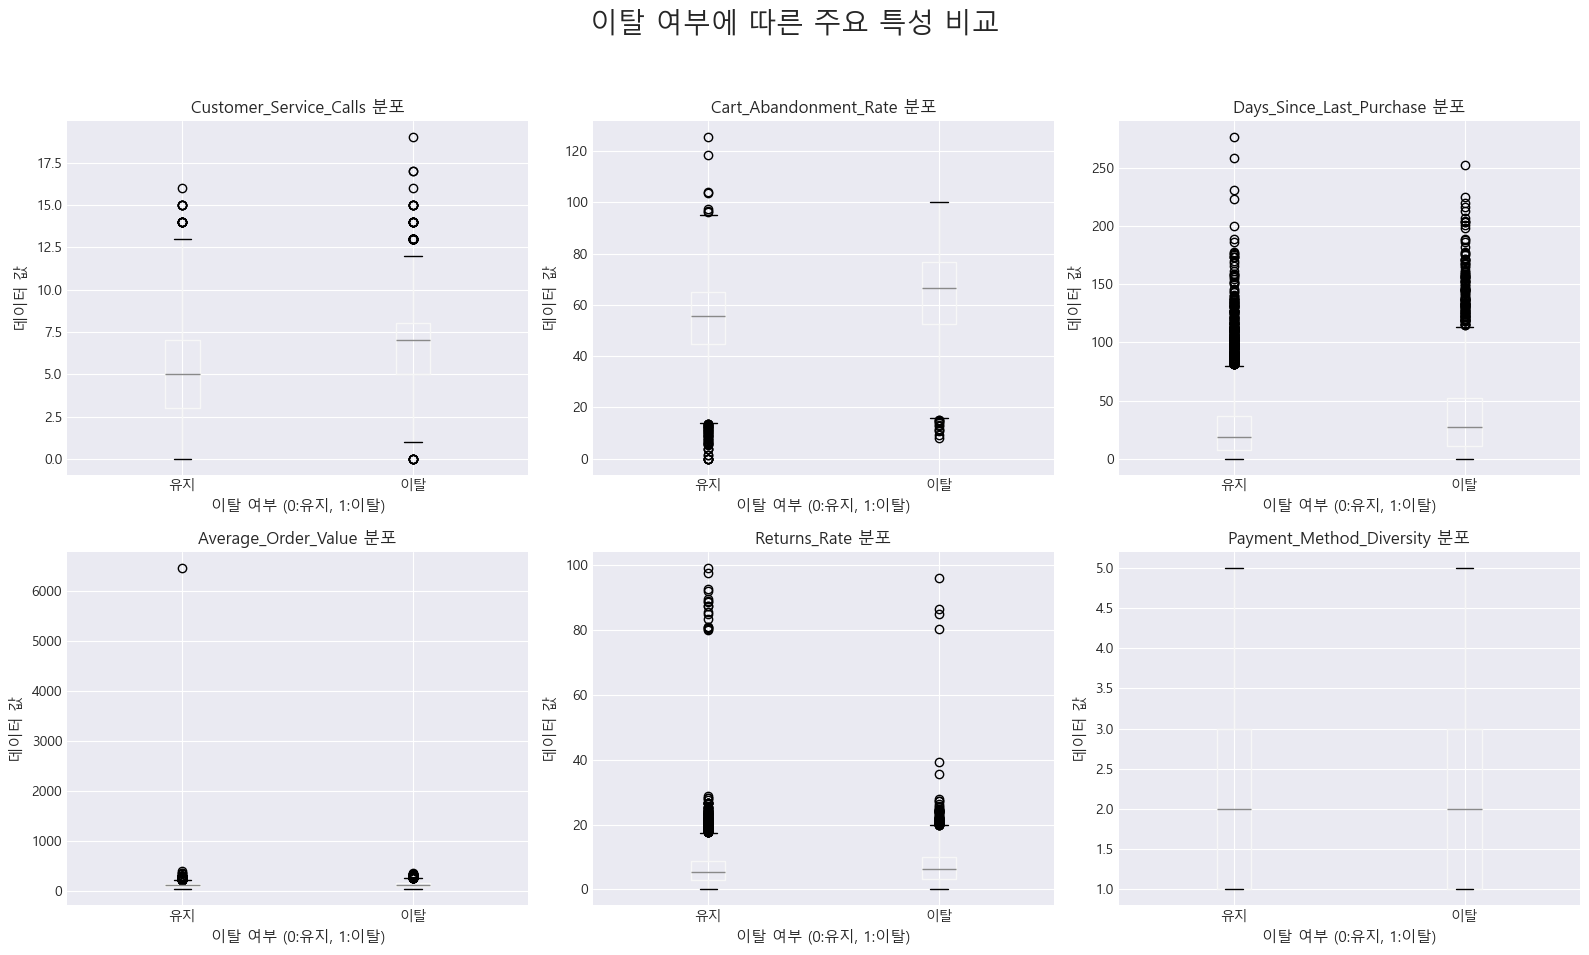

In [12]:
# 3.7 이탈 여부에 따른 주요 변수 분포 비교 (안전 모드)
import matplotlib.pyplot as plt

# 한글 폰트 이름 설정 (Windows)
font_name = "Malgun Gothic"

# 이전 셀에서 만든 target_corr이 있어야 합니다.
try:
    top_corr_features = target_corr.abs().head(6).index.tolist()
except NameError:
    # 혹시 target_corr이 없다면 수동으로 6개 지정 (임시)
    top_corr_features = numeric_cols[:6]

# 그래프 생성 (여기서 시간이 조금 걸릴 수 있으니 기다려주세요!)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(top_corr_features):
    # 박스플롯 그리기
    df.boxplot(column=col, by='Churned', ax=axes[idx])
    
    # 제목 및 라벨 폰트 설정
    axes[idx].set_title(f'{col} 분포', fontsize=12, family=font_name)
    axes[idx].set_xlabel('이탈 여부 (0:유지, 1:이탈)', fontsize=11, family=font_name)
    axes[idx].set_ylabel('데이터 값', fontsize=11, family=font_name)
    
    # 축 눈금 글자 깨짐 방지
    axes[idx].set_xticklabels(['유지', '이탈'], family=font_name, fontsize=10)

# 불필요한 자동 제목 제거 및 전체 제목 설정
plt.suptitle('') 
fig.suptitle('이탈 여부에 따른 주요 특성 비교', fontsize=20, family=font_name, y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. 데이터 전처리

### 4.1 결측치 처리

In [13]:
print("="*70)
print("결측치 처리")
print("="*70)

df_processed = df.copy()

print(f"\n처리 전 결측치 총 개수: {df_processed.isnull().sum().sum():,}\n")

# 결측치 처리 전략:
# 1. 결측치 비율이 높은 컬럼 확인
# 2. 수치형: 중앙값 대체 (평균보다 이상치에 강건)
# 3. 범주형: 최빈값 대체

missing_before = df_processed.isnull().sum()
cols_with_missing = missing_before[missing_before > 0].index.tolist()

# 수치형 변수 처리
numeric_missing = [col for col in cols_with_missing if col in numeric_cols]
if numeric_missing:
    print("📊 수치형 변수 결측치 처리 (중앙값 대체):")
    for col in numeric_missing:
        median_value = df_processed[col].median()
        missing_count = df_processed[col].isnull().sum()
        df_processed[col].fillna(median_value, inplace=True)
        print(f"   ✓ {col}")
        print(f"      - 결측치: {missing_count}개 ({missing_count/len(df)*100:.2f}%)")
        print(f"      - 대체값: {median_value:.2f} (중앙값)")

# 범주형 변수 처리
categorical_missing = [col for col in cols_with_missing if col in categorical_cols]
if categorical_missing:
    print(f"\n📝 범주형 변수 결측치 처리 (최빈값 대체):")
    for col in categorical_missing:
        mode_value = df_processed[col].mode()[0]
        missing_count = df_processed[col].isnull().sum()
        df_processed[col].fillna(mode_value, inplace=True)
        print(f"   ✓ {col}")
        print(f"      - 결측치: {missing_count}개 ({missing_count/len(df)*100:.2f}%)")
        print(f"      - 대체값: '{mode_value}' (최빈값)")

print(f"\n{'='*70}")
print(f"✅ 결측치 처리 완료")
print(f"   처리 전: {missing_before.sum():,}개")
print(f"   처리 후: {df_processed.isnull().sum().sum():,}개")
print(f"   처리된 컬럼 수: {len(cols_with_missing)}개")
print(f"{'='*70}")

결측치 처리

처리 전 결측치 총 개수: 9,898

📊 수치형 변수 결측치 처리 (중앙값 대체):
   ✓ Age
      - 결측치: 531개 (5.31%)
      - 대체값: 38.00 (중앙값)
   ✓ Session_Duration_Avg
      - 결측치: 641개 (6.41%)
      - 대체값: 26.80 (중앙값)
   ✓ Pages_Per_Session
      - 결측치: 619개 (6.19%)
      - 대체값: 8.40 (중앙값)
   ✓ Wishlist_Items
      - 결측치: 805개 (8.05%)
      - 대체값: 4.00 (중앙값)
   ✓ Days_Since_Last_Purchase
      - 결측치: 597개 (5.97%)
      - 대체값: 21.00 (중앙값)
   ✓ Discount_Usage_Rate
      - 결측치: 692개 (6.92%)
      - 대체값: 40.20 (중앙값)
   ✓ Returns_Rate
      - 결측치: 925개 (9.25%)
      - 대체값: 5.50 (중앙값)
   ✓ Email_Open_Rate
      - 결측치: 523개 (5.23%)
      - 대체값: 19.70 (중앙값)
   ✓ Customer_Service_Calls
      - 결측치: 40개 (0.40%)
      - 대체값: 5.00 (중앙값)
   ✓ Product_Reviews_Written
      - 결측치: 700개 (7.00%)
      - 대체값: 2.00 (중앙값)
   ✓ Social_Media_Engagement_Score
      - 결측치: 1256개 (12.56%)
      - 대체값: 27.50 (중앙값)
   ✓ Mobile_App_Usage
      - 결측치: 975개 (9.75%)
      - 대체값: 18.50 (중앙값)
   ✓ Payment_Method_Diversity
      - 결측치: 494개 (4

### 4.2 범주형 변수 인코딩

In [15]:
# Label Encoding
label_encoders = {}

if len(categorical_cols) > 0:
    print("\n범주형 변수 인코딩:")
    print("="*50)
    
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"✓ {col}: {len(le.classes_)}개 클래스 → 0~{len(le.classes_)-1}로 변환")
    
    print("\n✅ 범주형 변수 인코딩 완료")
else:
    print("\n범주형 변수가 없습니다.")


범주형 변수 인코딩:
✓ Gender: 3개 클래스 → 0~2로 변환
✓ Country: 8개 클래스 → 0~7로 변환
✓ City: 40개 클래스 → 0~39로 변환
✓ Signup_Quarter: 4개 클래스 → 0~3로 변환

✅ 범주형 변수 인코딩 완료


### 4.3 Feature Selection (중요 특성 선택)

**3단계 Feature Selection 전략:**
1. **다중공선성 제거**: 상관관계가 너무 높은 변수 제거 (0.9 이상)
2. **타겟 상관관계 분석**: 타겟과의 상관관계 확인
3. **Random Forest 중요도**: 최종 중요 특성 선택

#### Step 1: 다중공선성 제거

In [16]:
print("="*70)
print("Step 1: 다중공선성 제거 (Multicollinearity Removal)")
print("="*70)

X_temp = df_processed.drop('Churned', axis=1)
y_temp = df_processed['Churned']

# 상관관계 행렬 계산
corr_matrix = X_temp.corr().abs()

# 상삼각 행렬만 사용 (중복 제거)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# 상관관계가 0.7 이상인 특성 찾기 (다중공선성 기준)
high_corr_features = [column for column in upper_triangle.columns 
                      if any(upper_triangle[column] > 0.7)]

if high_corr_features:
    print(f"\n⚠️  높은 상관관계 (>0.7) 특성 발견: {len(high_corr_features)}개")
    for feat in high_corr_features:
        # 어떤 특성과 높은 상관관계를 가지는지 찾기
        correlated_with = upper_triangle[feat][upper_triangle[feat] > 0.7].index.tolist()
        if correlated_with:
            for corr_feat in correlated_with:
                print(f"   - {feat} ↔ {corr_feat}: {upper_triangle[feat][corr_feat]:.3f}")
    
    # 다중공선성이 있는 특성 제거
    X_temp = X_temp.drop(columns=high_corr_features)
    print(f"\n✅ 제거 완료: {len(high_corr_features)}개 특성 제거")
    print(f"   제거된 특성: {', '.join(high_corr_features)}")
else:
    print(f"\n✅ 높은 다중공선성 없음 (상관관계 < 0.7)")

print(f"\n남은 특성 수: {len(X_temp.columns)}개")
print("="*70)

Step 1: 다중공선성 제거 (Multicollinearity Removal)

⚠️  높은 상관관계 (>0.7) 특성 발견: 1개
   - Pages_Per_Session ↔ Session_Duration_Avg: 0.710

✅ 제거 완료: 1개 특성 제거
   제거된 특성: Pages_Per_Session

남은 특성 수: 23개


#### Step 2: 타겟 상관관계 분석


Step 2: 타겟 변수와의 상관관계 분석


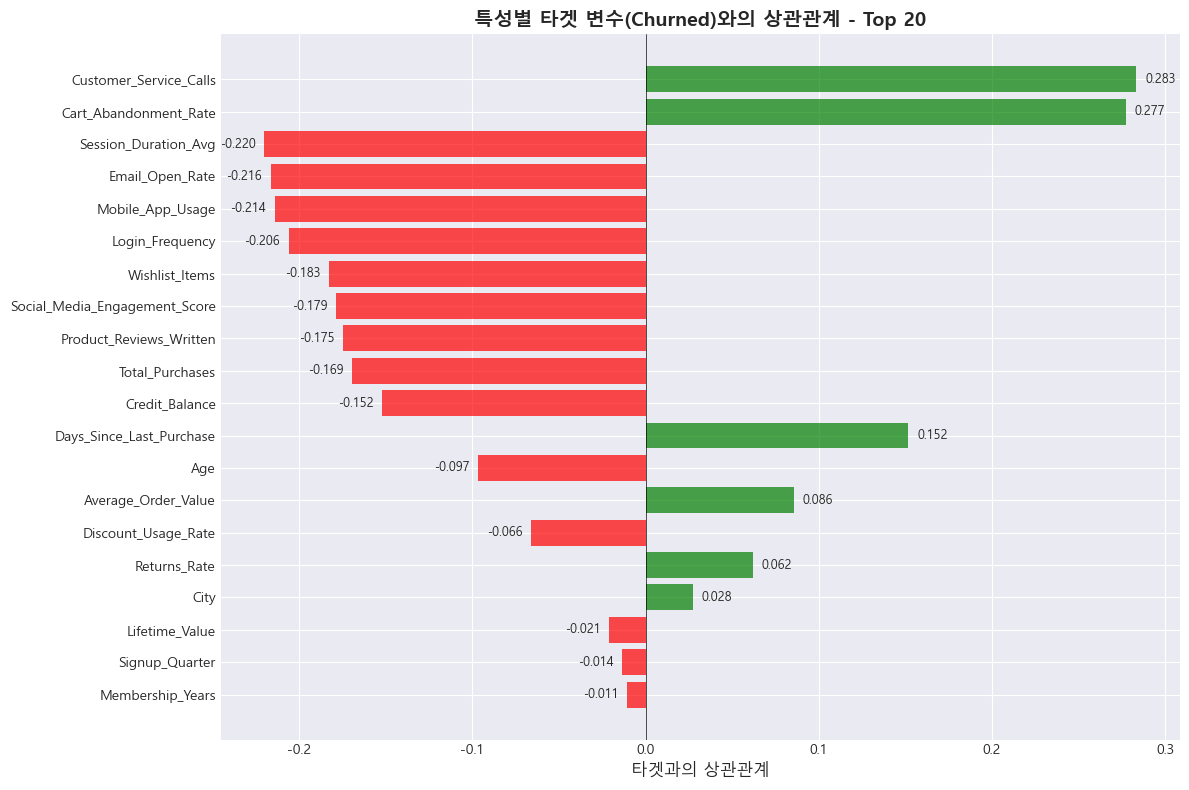


타겟과의 상관관계 Top 15:
                      feature  correlation
       Customer_Service_Calls     0.283352
        Cart_Abandonment_Rate     0.277238
         Session_Duration_Avg    -0.220027
              Email_Open_Rate    -0.216352
             Mobile_App_Usage    -0.214133
              Login_Frequency    -0.206075
               Wishlist_Items    -0.182825
Social_Media_Engagement_Score    -0.178520
      Product_Reviews_Written    -0.174611
              Total_Purchases    -0.169306
               Credit_Balance    -0.151941
     Days_Since_Last_Purchase     0.151766
                          Age    -0.096598
          Average_Order_Value     0.085521
          Discount_Usage_Rate    -0.066004

⚠️  타겟과 상관관계가 매우 낮은 특성 (3개):
   - Payment_Method_Diversity: 0.0099
   - Gender: -0.0047
   - Country: 0.0012


In [17]:
print("\n" + "="*70)
print("Step 2: 타겟 변수와의 상관관계 분석")
print("="*70)

# 타겟과의 상관관계 계산
target_correlation = pd.DataFrame({
    'feature': X_temp.columns,
    'correlation': [X_temp[col].corr(y_temp) for col in X_temp.columns]
}).sort_values('correlation', key=abs, ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in target_correlation['correlation'][:20]]
plt.barh(range(len(target_correlation[:20])), 
         target_correlation['correlation'][:20], 
         color=colors, alpha=0.7)
plt.yticks(range(len(target_correlation[:20])), target_correlation['feature'][:20])
plt.xlabel('타겟과의 상관관계', fontsize=12)
plt.title('특성별 타겟 변수(Churned)와의 상관관계 - Top 20', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()

# 값 표시
for i, v in enumerate(target_correlation['correlation'][:20]):
    plt.text(v + 0.005 if v > 0 else v - 0.005, i, f'{v:.3f}', 
             va='center', ha='left' if v > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()

print("\n타겟과의 상관관계 Top 15:")
print("="*70)
print(target_correlation.head(15).to_string(index=False))

# 상관관계가 매우 낮은 특성 식별 (절대값 < 0.01)
low_corr_features = target_correlation[target_correlation['correlation'].abs() < 0.01]['feature'].tolist()
if low_corr_features:
    print(f"\n⚠️  타겟과 상관관계가 매우 낮은 특성 ({len(low_corr_features)}개):")
    for feat in low_corr_features:
        corr_val = target_correlation[target_correlation['feature']==feat]['correlation'].values[0]
        print(f"   - {feat}: {corr_val:.4f}")
else:
    print(f"\n✅ 모든 특성이 타겟과 유의미한 상관관계를 가짐")

print("="*70)

#### Step 3: Random Forest 기반 특성 중요도


Step 3: Random Forest 기반 Feature Importance


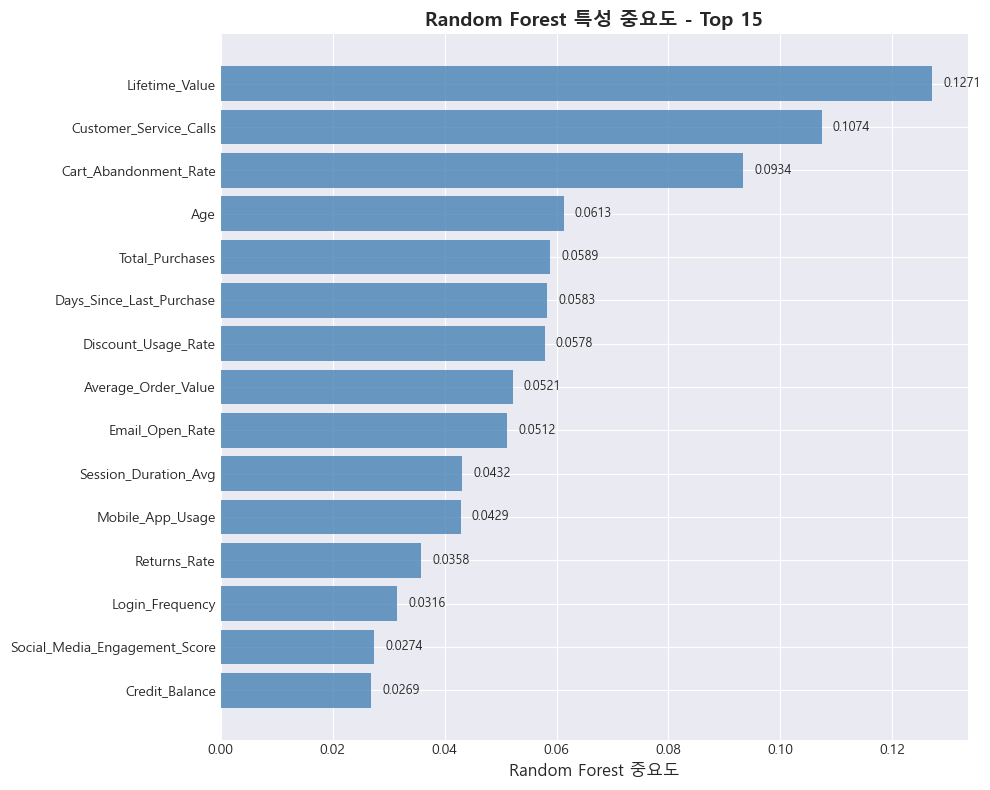


특성 중요도 순위 (종합):
                      feature  rf_importance  target_corr  cumulative_importance
               Lifetime_Value       0.127144    -0.021142               0.127144
       Customer_Service_Calls       0.107378     0.283352               0.234522
        Cart_Abandonment_Rate       0.093387     0.277238               0.327910
                          Age       0.061289    -0.096598               0.389199
              Total_Purchases       0.058903    -0.169306               0.448102
     Days_Since_Last_Purchase       0.058310     0.151766               0.506412
          Discount_Usage_Rate       0.057850    -0.066004               0.564261
          Average_Order_Value       0.052142     0.085521               0.616403
              Email_Open_Rate       0.051173    -0.216352               0.667576
         Session_Duration_Avg       0.043186    -0.220027               0.710761
             Mobile_App_Usage       0.042863    -0.214133               0.753624
           

In [18]:
print("\n" + "="*70)
print("Step 3: Random Forest 기반 Feature Importance")
print("="*70)

# Random Forest로 특성 중요도 계산
from sklearn.ensemble import RandomForestClassifier

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_temp, y_temp)

# 특성 중요도 데이터프레임
feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'rf_importance': rf_temp.feature_importances_,
    'target_corr': [X_temp[col].corr(y_temp) for col in X_temp.columns]
}).sort_values('rf_importance', ascending=False)

# 누적 중요도 계산
feature_importance['cumulative_importance'] = feature_importance['rf_importance'].cumsum()

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], 
         feature_importance['rf_importance'][:15], 
         color='steelblue', alpha=0.8)
plt.xlabel('Random Forest 중요도', fontsize=12)
plt.title('Random Forest 특성 중요도 - Top 15', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# 값 표시
for i, (idx, row) in enumerate(feature_importance.head(15).iterrows()):
    plt.text(row['rf_importance'] + 0.002, i, f"{row['rf_importance']:.4f}", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n특성 중요도 순위 (종합):")
print("="*70)
print(feature_importance[['feature', 'rf_importance', 'target_corr', 'cumulative_importance']].head(20).to_string(index=False))

# 상위 15개 특성 선택 (누적 중요도 ~85%)
n_features = 15
selected_features = feature_importance['feature'][:n_features].tolist()
cumulative_imp = feature_importance['cumulative_importance'].iloc[n_features-1]

print(f"\n" + "="*70)
print("✅ Feature Selection 최종 결과")
print("="*70)
print(f"   - 원본 특성: {len(df_processed.columns)-1}개")
print(f"   - 다중공선성 제거 후: {len(X_temp.columns)}개")
print(f"   - 최종 선택 특성: {n_features}개")
print(f"   - 누적 RF 중요도: {cumulative_imp*100:.2f}%")
print(f"   - 특성 감소율: {(1-n_features/(len(df_processed.columns)-1))*100:.1f}%")
print("="*70)

In [19]:
# 선택된 특성으로 데이터셋 구성
X = df_processed[selected_features]
y = df_processed['Churned']

print(f"\n최종 데이터셋 크기:")
print(f"   X (특성): {X.shape}")
print(f"   y (타겟): {y.shape}")

print(f"\n선택된 특성 목록:")
for i, feat in enumerate(selected_features, 1):
    print(f"   {i:2d}. {feat}")


최종 데이터셋 크기:
   X (특성): (10000, 15)
   y (타겟): (10000,)

선택된 특성 목록:
    1. Lifetime_Value
    2. Customer_Service_Calls
    3. Cart_Abandonment_Rate
    4. Age
    5. Total_Purchases
    6. Days_Since_Last_Purchase
    7. Discount_Usage_Rate
    8. Average_Order_Value
    9. Email_Open_Rate
   10. Session_Duration_Avg
   11. Mobile_App_Usage
   12. Returns_Rate
   13. Login_Frequency
   14. Social_Media_Engagement_Score
   15. Credit_Balance


### 4.4 데이터 분할 (Train/Test Split)

In [20]:
# 학습/테스트 데이터 분할 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*70)
print("데이터 분할")
print("="*70)
print(f"\n학습 데이터:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   이탈률: {y_train.mean()*100:.2f}%")

print(f"\n테스트 데이터:")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")
print(f"   이탈률: {y_test.mean()*100:.2f}%")

데이터 분할

학습 데이터:
   X_train: (8000, 15)
   y_train: (8000,)
   이탈률: 28.90%

테스트 데이터:
   X_test: (2000, 15)
   y_test: (2000,)
   이탈률: 28.90%


### 4.5 데이터 스케일링 (Standardization)

In [21]:
# StandardScaler 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ 데이터 스케일링 완료 (StandardScaler)")
print(f"\n스케일링 전 - 평균: {X_train.mean().mean():.2f}, 표준편차: {X_train.std().mean():.2f}")
print(f"스케일링 후 - 평균: {X_train_scaled.mean():.2f}, 표준편차: {X_train_scaled.std():.2f}")

✅ 데이터 스케일링 완료 (StandardScaler)

스케일링 전 - 평균: 253.66, 표준편차: 153.00
스케일링 후 - 평균: -0.00, 표준편차: 1.00


### 4.6 클래스 불균형 처리 (SMOTE)

In [22]:
print("="*70)
print("클래스 불균형 처리 (SMOTE)")
print("="*70)

print(f"\nSMOTE 적용 전:")
print(f"   유지(0): {(y_train==0).sum():,}")
print(f"   이탈(1): {(y_train==1).sum():,}")
print(f"   불균형 비율: {(y_train==0).sum()/(y_train==1).sum():.2f}:1")

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nSMOTE 적용 후:")
print(f"   유지(0): {(y_train_resampled==0).sum():,}")
print(f"   이탈(1): {(y_train_resampled==1).sum():,}")
print(f"   불균형 비율: 1:1 (균형 달성)")

print(f"\n✅ SMOTE 처리 완료")
print(f"   학습 데이터 증가: {len(y_train):,} → {len(y_train_resampled):,}")

클래스 불균형 처리 (SMOTE)

SMOTE 적용 전:
   유지(0): 5,688
   이탈(1): 2,312
   불균형 비율: 2.46:1

SMOTE 적용 후:
   유지(0): 5,688
   이탈(1): 5,688
   불균형 비율: 1:1 (균형 달성)

✅ SMOTE 처리 완료
   학습 데이터 증가: 8,000 → 11,376


## 5. 모델 학습 및 평가

### 5.1 베이스라인 모델 비교

In [ ]:
# 여러 모델 정의
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
}

# 모델 학습 및 평가
results = []

print("="*70)
print("모델 학습 및 평가")
print("="*70)

for name, model in models.items():
    print(f"\n📊 {name} 학습 중...")
    
    # 학습
    model.fit(X_train_resampled, y_train_resampled)
    
    # 예측
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # 평가 지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # 교차 검증 (5-Fold)
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                 cv=5, scoring='roc_auc')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV Mean': cv_mean,
        'CV Std': cv_std
    })
    
    print(f"   ✓ Accuracy: {accuracy:.4f}")
    print(f"   ✓ Precision: {precision:.4f}")
    print(f"   ✓ Recall: {recall:.4f}")
    print(f"   ✓ F1-Score: {f1:.4f}")
    print(f"   ✓ ROC-AUC: {roc_auc:.4f}")
    print(f"   ✓ CV Score: {cv_mean:.4f} (±{cv_std:.4f})")

# 결과 데이터프레임
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*70)
print("모델 성능 비교 결과")
print("="*70)
print(results_df.to_string(index=False))

# 최고 성능 모델
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 최고 성능 모델: {best_model_name}")
print(f"   ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}")

NameError: name 'LGBMClassifier' is not defined

### 5.2 모델 성능 시각화

In [ ]:
# 성능 지표 비교 막대 그래프
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'CV Mean']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for idx, metric in enumerate(metrics):
    axes[idx].barh(results_df['Model'], results_df[metric], color=colors[idx], alpha=0.8)
    axes[idx].set_xlabel(metric, fontsize=11)
    axes[idx].set_title(f'{metric} 비교', fontsize=12, fontweight='bold')
    axes[idx].set_xlim([0, 1])
    
    # 값 표시
    for i, v in enumerate(results_df[metric]):
        axes[idx].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.suptitle('모델별 성능 지표 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.3 하이퍼파라미터 튜닝 (GridSearchCV)

In [ ]:
print("="*70)
print(f"{best_model_name} 하이퍼파라미터 튜닝")
print("="*70)

# XGBoost 하이퍼파라미터 그리드 (예시)
if best_model_name == 'XGBoost':
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200],
        'subsample': [0.8, 1.0]
    }
    base_model = XGBClassifier(random_state=42, eval_metric='logloss')

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)

elif best_model_name == 'LightGBM':
    param_grid = {
        'num_leaves': [20, 31, 50],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200]
    }
    base_model = LGBMClassifier(random_state=42, verbose=-1)

else:
    param_grid = {}
    base_model = models[best_model_name]

# GridSearchCV 실행
if param_grid:
    print(f"\n그리드 서치 시작... (이 작업은 시간이 걸릴 수 있습니다)\n")
    
    grid_search = GridSearchCV(
        base_model, param_grid, cv=3, scoring='roc_auc', 
        n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    print(f"\n✅ 하이퍼파라미터 튜닝 완료")
    print(f"\n최적 파라미터:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param}: {value}")
    
    print(f"\n최고 CV 점수: {grid_search.best_score_:.4f}")
    
    # 최적 모델로 업데이트
    best_model = grid_search.best_estimator_
else:
    print(f"\n⚠️ {best_model_name}에 대한 하이퍼파라미터 튜닝을 건너뜁니다.")
    best_model = models[best_model_name]
    best_model.fit(X_train_resampled, y_train_resampled)

### 5.4 최종 모델 평가

In [ ]:
# 최종 예측
y_pred_final = best_model.predict(X_test_scaled)
y_pred_proba_final = best_model.predict_proba(X_test_scaled)[:, 1]

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred_final)

print("="*70)
print(f"최종 모델 평가 ({best_model_name})")
print("="*70)

print(f"\n📊 성능 지표:")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_final):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_final):.4f}")
print(f"   F1-Score:  {f1_score(y_test, y_pred_final):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_final):.4f}")

print(f"\n📋 혼동 행렬:")
print(cm)
print(f"\n   True Negative (TN):  {cm[0,0]}")
print(f"   False Positive (FP): {cm[0,1]}")
print(f"   False Negative (FN): {cm[1,0]}")
print(f"   True Positive (TP):  {cm[1,1]}")

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['유지 (0)', '이탈 (1)'], 
            yticklabels=['유지 (0)', '이탈 (1)'])
plt.ylabel('실제 값', fontsize=12)
plt.xlabel('예측 값', fontsize=12)
plt.title(f'혼동 행렬 (Confusion Matrix) - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 분류 리포트
print(f"\n📄 분류 리포트:")
print(classification_report(y_test, y_pred_final, target_names=['유지', '이탈']))

### 5.5 ROC Curve 및 PR Curve

In [ ]:
# ROC Curve와 Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_final)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_final)
pr_auc = auc(recall_vals, precision_vals)

axes[1].plot(recall_vals, precision_vals, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[1].legend(loc="lower left")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.6 Feature Importance (최종 모델)

In [ ]:
# Feature Importance (트리 기반 모델인 경우)
if hasattr(best_model, 'feature_importances_'):
    feature_importance_final = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_final['feature'], feature_importance_final['importance'], color='steelblue')
    plt.xlabel('중요도', fontsize=12)
    plt.title(f'{best_model_name} - Feature Importance (최종 모델)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    
    for i, v in enumerate(feature_importance_final['importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n특성 중요도 순위 (최종 모델):")
    print("="*50)
    print(feature_importance_final.to_string(index=False))
else:
    print(f"{best_model_name}은 feature importance를 제공하지 않습니다.")

## 6. 모델 저장

In [ ]:
# 모델과 전처리 객체들을 함께 저장
model_package = {
    'model': best_model,
    'model_name': best_model_name,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_names': selected_features,
    'performance_metrics': {
        'accuracy': accuracy_score(y_test, y_pred_final),
        'precision': precision_score(y_test, y_pred_final),
        'recall': recall_score(y_test, y_pred_final),
        'f1_score': f1_score(y_test, y_pred_final),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_final)
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'all_results': results_df.to_dict('records'),
    'feature_selection': {
        'applied': True,
        'original_features': len(df.columns) - 1,
        'selected_features': n_features,
        'reduction_rate': f"{(1-n_features/(len(df.columns)-1))*100:.1f}%",
        'cumulative_importance': f"{cumulative_imp*100:.2f}%"
    },
    'preprocessing': {
        'missing_value_handling': 'median (numeric), mode (categorical)',
        'scaling': 'StandardScaler',
        'class_balancing': 'SMOTE',
        'encoding': 'LabelEncoder'
    }
}

# pkl 파일로 저장
with open('churn_model_final.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("="*70)
print("모델 저장 완료")
print("="*70)
print(f"\n파일명: churn_model_final.pkl")
print(f"\n저장된 정보:")
print(f"   - 모델: {best_model_name}")
print(f"   - ROC-AUC: {model_package['performance_metrics']['roc_auc']:.4f}")
print(f"   - 특성 개수: {len(selected_features)}")
print(f"   - Feature Selection: {model_package['feature_selection']['reduction_rate']} 감소")
print(f"   - 학습 날짜: {model_package['training_date']}")

# 모델 파일 크기 확인
import os
file_size = os.path.getsize('churn_model_final.pkl') / (1024 * 1024)  # MB
print(f"\n모델 파일 크기: {file_size:.2f} MB")

## 7. 최종 요약

In [ ]:
print("="*70)
print("전자상거래 고객 이탈 예측 모델 개발 완료")
print("="*70)

print(f"\n📊 데이터셋 정보:")
print(f"   - 총 샘플 수: {len(df):,}")
print(f"   - 원본 특성: {len(df.columns)-1}개")
print(f"   - 선택 특성: {n_features}개 ({(1-n_features/(len(df.columns)-1))*100:.1f}% 감소)")
print(f"   - 이탈률: {df['Churned'].mean()*100:.2f}%")

print(f"\n🔧 전처리 과정:")
print(f"   ✓ 결측치 처리: 중앙값/최빈값 대체")
print(f"   ✓ 범주형 인코딩: Label Encoding")
print(f"   ✓ Feature Selection: 상위 {n_features}개 (누적 중요도 {cumulative_imp*100:.2f}%)")
print(f"   ✓ 데이터 스케일링: StandardScaler")
print(f"   ✓ 클래스 불균형: SMOTE 적용")

print(f"\n🤖 평가한 모델 수: {len(models)}")
print(f"   - {', '.join(models.keys())}")

print(f"\n🏆 최고 성능 모델: {best_model_name}")

print(f"\n📈 성능 지표 (테스트 데이터):")
print(f"   - Accuracy:  {model_package['performance_metrics']['accuracy']:.4f}")
print(f"   - Precision: {model_package['performance_metrics']['precision']:.4f}")
print(f"   - Recall:    {model_package['performance_metrics']['recall']:.4f}")
print(f"   - F1-Score:  {model_package['performance_metrics']['f1_score']:.4f}")
print(f"   - ROC-AUC:   {model_package['performance_metrics']['roc_auc']:.4f}")

print(f"\n💾 저장된 파일: churn_model_final.pkl ({file_size:.2f} MB)")

print(f"\n✨ 다음 단계:")
print(f"   1. 웹 애플리케이션에서 모델 로드")
print(f"   2. 실시간 고객 이탈 예측")
print(f"   3. 대시보드 시각화")
print(f"   4. 이탈 방지 전략 수립")

print("\n" + "="*70)
print("🎉 모델 개발 완료!")
print("="*70)